In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from example_lorenz import get_lorenz_data, generate_lorenz_data
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() 
%matplotlib inline

#### List of experiment names

In [2]:
file_names = [f'lorenz_exp{i}_seed{123+i}' for i in range(13)]
print(file_names)

['lorenz_exp0_seed123', 'lorenz_exp1_seed124', 'lorenz_exp2_seed125', 'lorenz_exp3_seed126', 'lorenz_exp4_seed127', 'lorenz_exp5_seed128', 'lorenz_exp6_seed129', 'lorenz_exp7_seed130', 'lorenz_exp8_seed131', 'lorenz_exp9_seed132', 'lorenz_exp10_seed133', 'lorenz_exp11_seed134', 'lorenz_exp12_seed135']


#### Build a dictionary of experiments
    Each experiment gets:
    - its own tf.Graph()
    - params
    - autoencoder_network
    - learning_rate placeholder
    - saver
    - tensorflow_run_tuple

In [3]:
data_path = os.getcwd() + '/'
lorenz_experiments = {}

for save_name in file_names:
    # Create a new, isolated graph for this model
    graph = tf.Graph()
    with graph.as_default():
        # Load parameters for this experiment
        params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
        params['save_name'] = data_path + save_name

        # Build the AE-SINDy network in THIS graph
        autoencoder_network = full_network(params)

        #learning_rate = tf.placeholder(tf.float32, name=f'learning_rate_{save_name}')
        learning_rate = tf.placeholder(tf.float32, name=f'learning_rate')

        # Saver for all variables in this graph
        saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

        # Tuple of tensors/ops we want to evaluate later
        tensorflow_run_tuple = ()
        for key in autoencoder_network.keys():
            tensorflow_run_tuple += (autoencoder_network[key],)

    # Store everything we need for this experiment
    lorenz_experiments[save_name] = {
        'graph': graph,
        'params': params,
        'network': autoencoder_network,
        'learning_rate': learning_rate,
        'saver': saver,
        'run_tuple': tensorflow_run_tuple,
    }

print("Loaded experiments:", lorenz_experiments.keys())



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Loaded experiments: dict_keys(['lorenz_exp0_seed123', 'lorenz_exp1_seed124', 'lorenz_exp2_seed125', 'lorenz_exp3_seed126', 'lorenz_exp4_seed127', 'lorenz_exp5_seed128', 'lorenz_exp6_seed129', 'lorenz_exp7_seed130', 'lorenz_exp8_seed131', 'lorenz_exp9_seed132', 'lorenz_exp10_seed133', 'lorenz_exp11_seed134', 'lorenz_exp12_seed135'])


## Single trajectory plots

#### Test trajectory

In [4]:
t = np.arange(0, 20, 0.01)
z0 = np.array([[-8, 7, 27]])

# params from one experiment to get input_dim / latent_dim
first_key = next(iter(lorenz_experiments.keys()))
first_params = lorenz_experiments[first_key]['params']

test_data = generate_lorenz_data(
    z0, t,
    first_params['input_dim'],
    linear=False,
    normalization=np.array([1/40, 1/40, 1/40])
)

# Reshape using those dimensions
test_data['x']  = test_data['x'].reshape((-1, first_params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1, first_params['input_dim']))
test_data['z']  = test_data['z'].reshape((-1, first_params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1, first_params['latent_dim']))


#### Model trajectories vs. test trajectories:
    - Storing them all in a dict()

In [11]:
test_data['z'][0]

array([-0.2  ,  0.175,  0.675])

In [5]:
single_traj_results = {}

for save_name, exp in lorenz_experiments.items():
    graph   = exp['graph']
    params  = exp['params']
    saver   = exp['saver']
    run_tpl = exp['run_tuple']
    network = exp['network']

    with tf.Session(graph=graph) as sess:
        # Initialize variables, then restore trained weights
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, params['save_name'])

        # Build feed_dict and run the network
        test_dictionary = create_feed_dictionary(test_data, params)
        tf_results = sess.run(run_tpl, feed_dict=test_dictionary)

    # Map results back to names (like in the original notebook)
    test_set_results = {}
    for i, key in enumerate(network.keys()):
        test_set_results[key] = tf_results[i]

    # Ground truth latent
    lorenz_sim = sindy_simulate(
        test_data['z'][0],
        t,
        test_data['sindy_coefficients'],
        params['poly_order'],
        params['include_sine'])

    # AE-SINDy latent
    z_sim = sindy_simulate(
        test_set_results['z'][0],
        t,
        params['coefficient_mask'] * test_set_results['sindy_coefficients'],
        params['poly_order'],
        params['include_sine'])

    # Store everything for later plotting / analysis
    single_traj_results[save_name] = {
        'test_set_results': test_set_results,
        'lorenz_sim': lorenz_sim,
        'z_sim': z_sim,
    }

print("Single-trajectory results for:", single_traj_results.keys())




INFO:tensorflow:Restoring parameters from c:\Users\local_user\Desktop\Study\VII_semester\DIL\Codes\SindyAutoencoders\examples\lorenz/lorenz_exp0_seed123
INFO:tensorflow:Restoring parameters from c:\Users\local_user\Desktop\Study\VII_semester\DIL\Codes\SindyAutoencoders\examples\lorenz/lorenz_exp1_seed124
INFO:tensorflow:Restoring parameters from c:\Users\local_user\Desktop\Study\VII_semester\DIL\Codes\SindyAutoencoders\examples\lorenz/lorenz_exp2_seed125
INFO:tensorflow:Restoring parameters from c:\Users\local_user\Desktop\Study\VII_semester\DIL\Codes\SindyAutoencoders\examples\lorenz/lorenz_exp3_seed126
INFO:tensorflow:Restoring parameters from c:\Users\local_user\Desktop\Study\VII_semester\DIL\Codes\SindyAutoencoders\examples\lorenz/lorenz_exp4_seed127
INFO:tensorflow:Restoring parameters from c:\Users\local_user\Desktop\Study\VII_semester\DIL\Codes\SindyAutoencoders\examples\lorenz/lorenz_exp5_seed128
INFO:tensorflow:Restoring parameters from c:\Users\local_user\Desktop\Study\VII_

#### Plot one

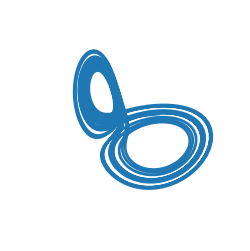

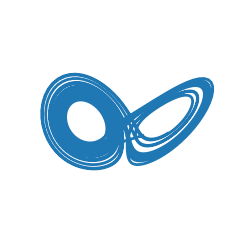

In [6]:
# Choose which experiment to visualize (you can change this string)
model_to_plot = 'lorenz_exp0_seed123'

res     = single_traj_results[model_to_plot]
z_sim   = res['z_sim']
lorenz_sim = res['lorenz_sim']

# 3D plot of the model's simulated attractor
fig1 = plt.figure(figsize=(3, 3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:, 0], z_sim[:, 1], z_sim[:, 2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

# 3D plot of the ground-truth Lorenz trajectory
fig2 = plt.figure(figsize=(3, 3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(lorenz_sim[:, 0], lorenz_sim[:, 1], lorenz_sim[:, 2], linewidth=2)
plt.xticks([])
plt.axis('off')
ax2.view_init(azim=120)


#### Comparisons
    - Trajectories, Xi sparsity, and time courses

In [7]:
# True Xi (same for all columns)
Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot == 0] = np.inf
# The original notebook did these manual fixes:
Xi_true_plot[6, 1] = -1.
Xi_true_plot[5, 2] = 1.


In [8]:
def get_Xi_plot_for_experiment(save_name):
    params = lorenz_experiments[save_name]['params']
    sindy_coeffs = single_traj_results[save_name]['test_set_results']['sindy_coefficients']
    Xi = params['coefficient_mask'] * sindy_coeffs
    Xi_plot = np.copy(Xi)
    Xi_plot[Xi_plot == 0] = np.inf
    return Xi_plot


##### Compare 2 experiments + ground truth

In [12]:
expA_name = 'lorenz_exp0_seed123'
expB_name = 'lorenz_exp1_seed124'

# Pull results
res_true = single_traj_results[expA_name]   # using expA's test run for lorenz_sim
res_A    = single_traj_results[expA_name]
res_B    = single_traj_results[expB_name]

lorenz_true = res_true['lorenz_sim']   # "ground truth" Lorenz sim
z_sim_A     = res_A['z_sim']
z_sim_B     = res_B['z_sim']

# Time series (latent z and SINDy sim z)
z_true_ts = res_true['lorenz_sim']             # latent "true" trajectory
z_A_ts    = res_A['test_set_results']['z']
z_B_ts    = res_B['test_set_results']['z']

# Xi matrices
Xi_true = Xi_true_plot
Xi_A    = get_Xi_plot_for_experiment(expA_name)
Xi_B    = get_Xi_plot_for_experiment(expB_name)


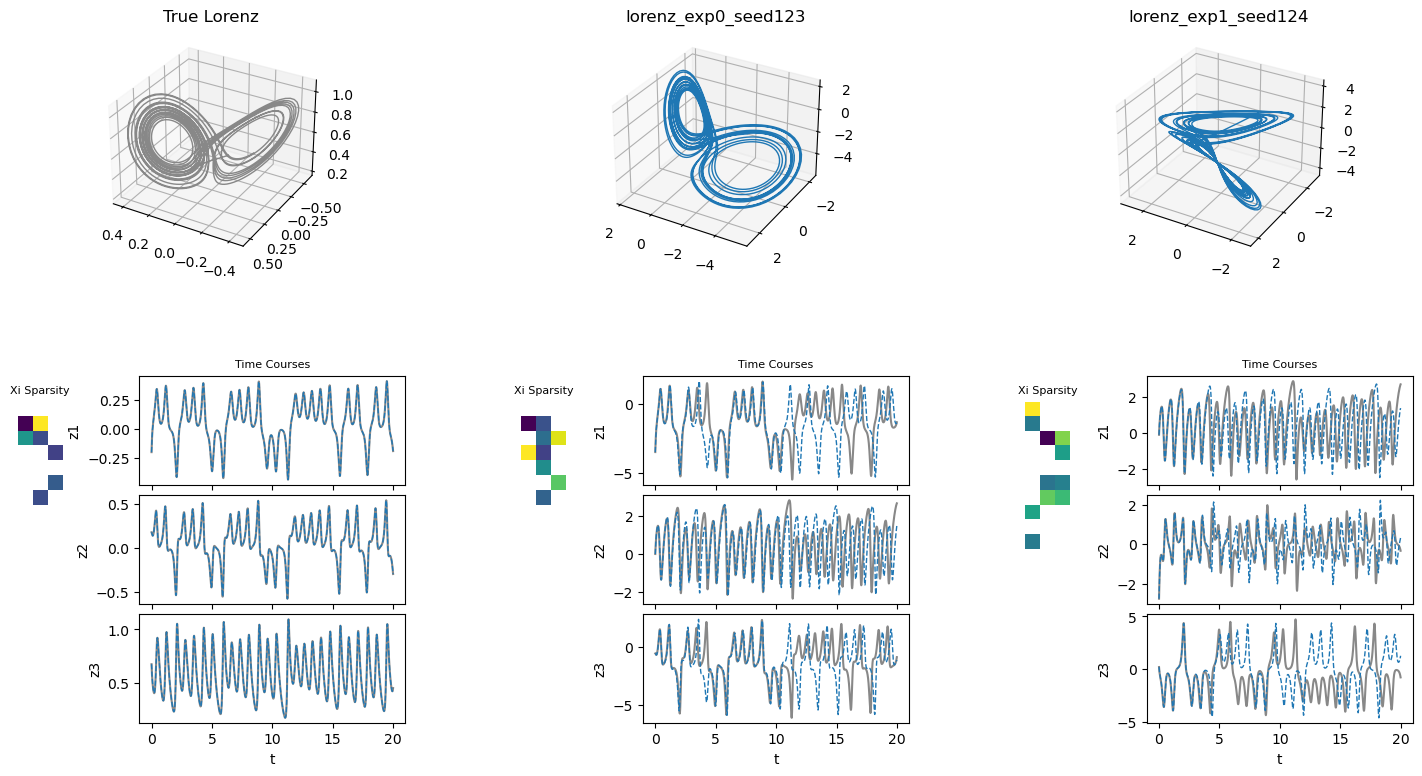

In [19]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

fig = plt.figure(figsize=(18, 9))

# Outer grid: 2 rows x 3 columns
outer = GridSpec(2, 3, height_ratios=[2, 3], hspace=0.4, wspace=0.3)

# -------------------
# Row 1: 3D attractors
# -------------------
ax_true = fig.add_subplot(outer[0, 0], projection='3d')
ax_A    = fig.add_subplot(outer[0, 1], projection='3d')
ax_B    = fig.add_subplot(outer[0, 2], projection='3d')

ax_true.plot(lorenz_true[:, 0], lorenz_true[:, 1], lorenz_true[:, 2],
             color='#888888', linewidth=1)
ax_true.set_title("True Lorenz")
#ax_true.axis('off')

ax_true.view_init(azim=120)

ax_A.plot(z_sim_A[:, 0], z_sim_A[:, 1], z_sim_A[:, 2], linewidth=1)
ax_A.set_title(expA_name)
#ax_A.axis('off')
ax_A.view_init(azim=120)

ax_B.plot(z_sim_B[:, 0], z_sim_B[:, 1], z_sim_B[:, 2], linewidth=1)
ax_B.set_title(expB_name)
#ax_B.axis('off')
ax_B.view_init(azim=120)

# -------------------
# Row 2: per-column panel with Xi (left) and time series (right)
# -------------------
columns = [
    ("True",      Xi_true, z_true_ts, lorenz_true),
    (expA_name,   Xi_A,    z_A_ts,    z_sim_A),
    (expB_name,   Xi_B,    z_B_ts,    z_sim_B),
]

for col_idx, (title, Xi, z_ts, z_sim) in enumerate(columns):
    # 1 row, 2 columns inside this outer cell
    inner = GridSpecFromSubplotSpec(
        1, 2,
        subplot_spec=outer[1, col_idx],
        width_ratios=[1, 6],  # Xi ~ 1/7, time series ~ 6/7
        wspace=0.5
    )

    # Xi sparsity (left)
    ax_xi = fig.add_subplot(inner[0, 0])
    ax_xi.imshow(Xi, interpolation='none')
    ax_xi.set_title(f"Xi Sparsity", fontsize=8)
    ax_xi.set_xticks([])
    ax_xi.set_yticks([])
    ax_xi.axis('off')

    # Time courses (right): 3 subplots stacked vertically
    ts_inner = GridSpecFromSubplotSpec(
        3, 1,
        subplot_spec=inner[0, 1],
        hspace=0.1
    )

    for i in range(3):
        ax_ts_i = fig.add_subplot(ts_inner[i, 0])
        ax_ts_i.plot(t, z_ts[:, i], color='#888888', linewidth=1.5)
        ax_ts_i.plot(t, z_sim[:, i], '--', linewidth=1)
        if i == 0:
            ax_ts_i.set_title(f"Time Courses", fontsize=8)
        ax_ts_i.set_xlabel('t')
        ax_ts_i.set_ylabel(f'z{i+1}')
        #ax_ts_i.set_xticks([])
        #ax_ts_i.set_yticks([])
        #ax_ts_i.axis('off')

plt.savefig(f"{expA_name.split('_seed')[0]+expB_name.split('_seed')[0]}", dpi=600)
#plt.tight_layout()
plt.show()


In [21]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def plot_lorenz_model_comparisons(
        exp_names,
        single_traj_results,
        Xi_true,
        get_Xi_plot_for_experiment,
        t,
        save_prefix="lorenz_compare",
        dpi=600,
        show=True,
):
    """
    Make one or more comparison figures.

    Each figure has:
      - left column:  true Lorenz (3D attractor + Xi_true + time series)
      - middle/right columns: up to two experiments from exp_names

    Parameters
    ----------
    exp_names : list of str
        Experiment names (keys in single_traj_results) to plot.
    single_traj_results : dict
        Mapping exp_name -> result dict (with keys 'lorenz_sim', 'z_sim',
        'test_set_results'->'z').
    Xi_true : np.ndarray
        Xi matrix for the true Lorenz system.
    get_Xi_plot_for_experiment : callable
        Function taking exp_name -> Xi matrix for that experiment.
    t : 1D array
        Time vector for the time series plots.
    save_prefix : str
        Prefix for the saved figure filenames.
    dpi : int
        Resolution for saved figures.
    show : bool
        Whether to call plt.show() at the end of each figure.
    """

    if len(exp_names) == 0:
        return

    # Use the first experiment entry to get the ground-truth Lorenz trajectory
    res0 = single_traj_results[exp_names[0]]
    lorenz_true = res0['lorenz_sim']
    z_true_ts   = lorenz_true  # for the lower panel we just plot truth vs truth

    # Process experiments in chunks of 2
    for fig_idx in range(0, len(exp_names), 2):
        group = exp_names[fig_idx:fig_idx+2]
        n_models = len(group)
        n_cols = 1 + n_models   # 1 for "True", then 1 or 2 models

        fig = plt.figure(figsize=(6 * n_cols, 9))
        outer = GridSpec(2, n_cols, height_ratios=[2, 3], hspace=0.4, wspace=0.3)

        # -------------------
        # Row 1: 3D attractors
        # -------------------
        # True Lorenz
        ax_true = fig.add_subplot(outer[0, 0], projection='3d')
        ax_true.plot(lorenz_true[:, 0], lorenz_true[:, 1], lorenz_true[:, 2],
                     color='#888888', linewidth=1)
        ax_true.set_title("True Lorenz")
        ax_true.view_init(azim=120)

        # Models
        for j, exp_name in enumerate(group):
            res = single_traj_results[exp_name]
            z_sim = res['z_sim']

            ax_model = fig.add_subplot(outer[0, 1 + j], projection='3d')
            ax_model.plot(z_sim[:, 0], z_sim[:, 1], z_sim[:, 2], linewidth=1)
            ax_model.set_title(exp_name)
            ax_model.view_init(azim=120)

        # -------------------
        # Row 2: Xi + time series
        # -------------------
        # Build the column definitions for the lower row
        columns = [("True", Xi_true, z_true_ts, lorenz_true)]
        for exp_name in group:
            res = single_traj_results[exp_name]
            Xi = get_Xi_plot_for_experiment(exp_name)
            z_ts = res['test_set_results']['z']
            z_sim = res['z_sim']
            columns.append((exp_name, Xi, z_ts, z_sim))

        for col_idx, (title, Xi, z_ts, z_sim) in enumerate(columns):
            inner = GridSpecFromSubplotSpec(
                1, 2,
                subplot_spec=outer[1, col_idx],
                width_ratios=[1, 6],
                wspace=0.5
            )

            # Xi sparsity
            ax_xi = fig.add_subplot(inner[0, 0])
            ax_xi.imshow(Xi, interpolation='none')
            ax_xi.set_title("Xi Sparsity", fontsize=8)
            ax_xi.set_xticks([])
            ax_xi.set_yticks([])
            ax_xi.axis('off')

            # Time courses
            ts_inner = GridSpecFromSubplotSpec(
                3, 1,
                subplot_spec=inner[0, 1],
                hspace=0.1
            )

            for i in range(3):
                ax_ts_i = fig.add_subplot(ts_inner[i, 0])
                ax_ts_i.plot(t, z_ts[:, i], color='#888888', linewidth=1.5)
                ax_ts_i.plot(t, z_sim[:, i], '--', linewidth=1)
                if i == 0:
                    ax_ts_i.set_title("Time Courses", fontsize=8)
                ax_ts_i.set_xlabel('t')
                ax_ts_i.set_ylabel(f'z{i+1}')

        # ---------
        # Save / show
        # ---------
        short_names = ["True"] + [name.split('_seed')[0] for name in group]
        suffix = "_vs_".join(short_names[1:])  # ignore "True" in filename
        filename = f"{save_prefix}_fig{fig_idx//2}_{suffix}.png"
        plt.savefig(filename, dpi=dpi, bbox_inches='tight')
        if show:
            plt.show()
        else:
            plt.close(fig)


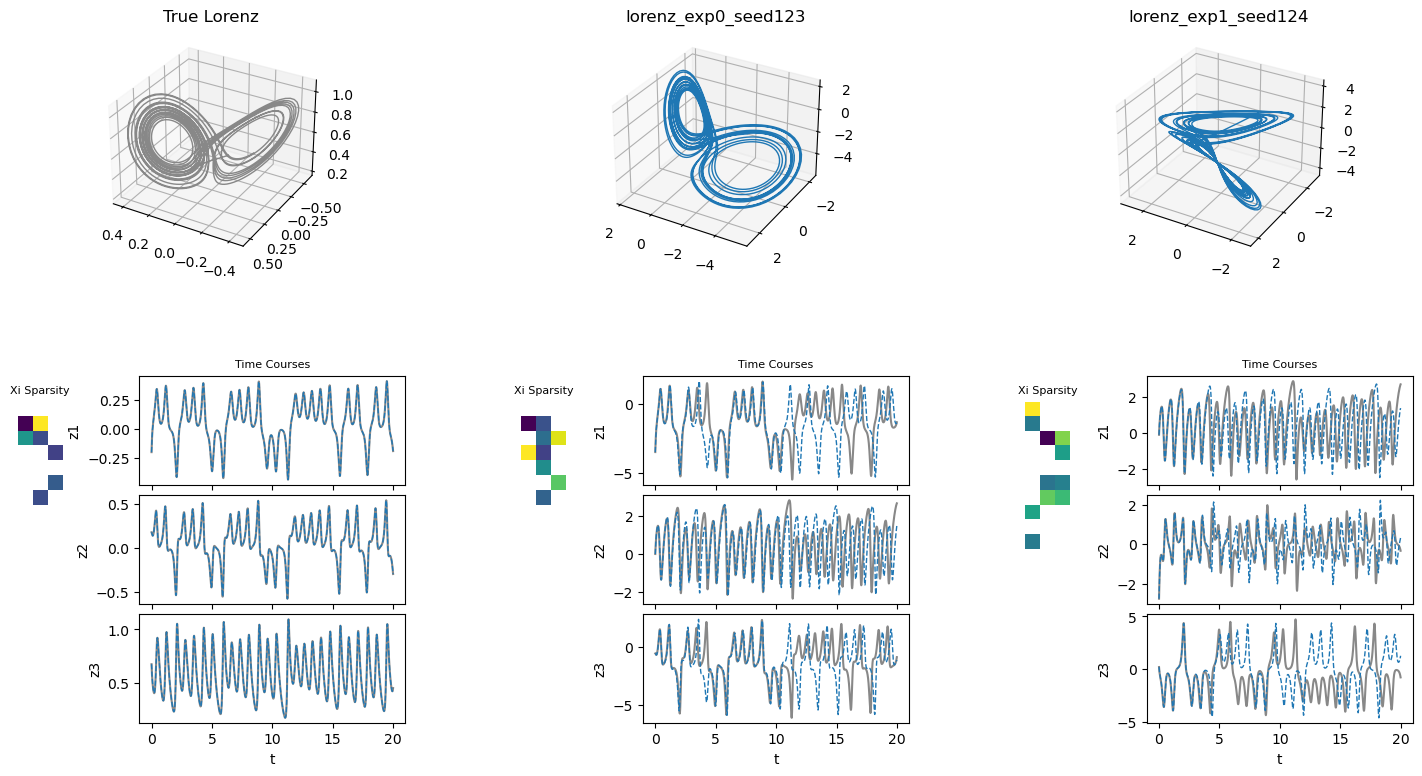

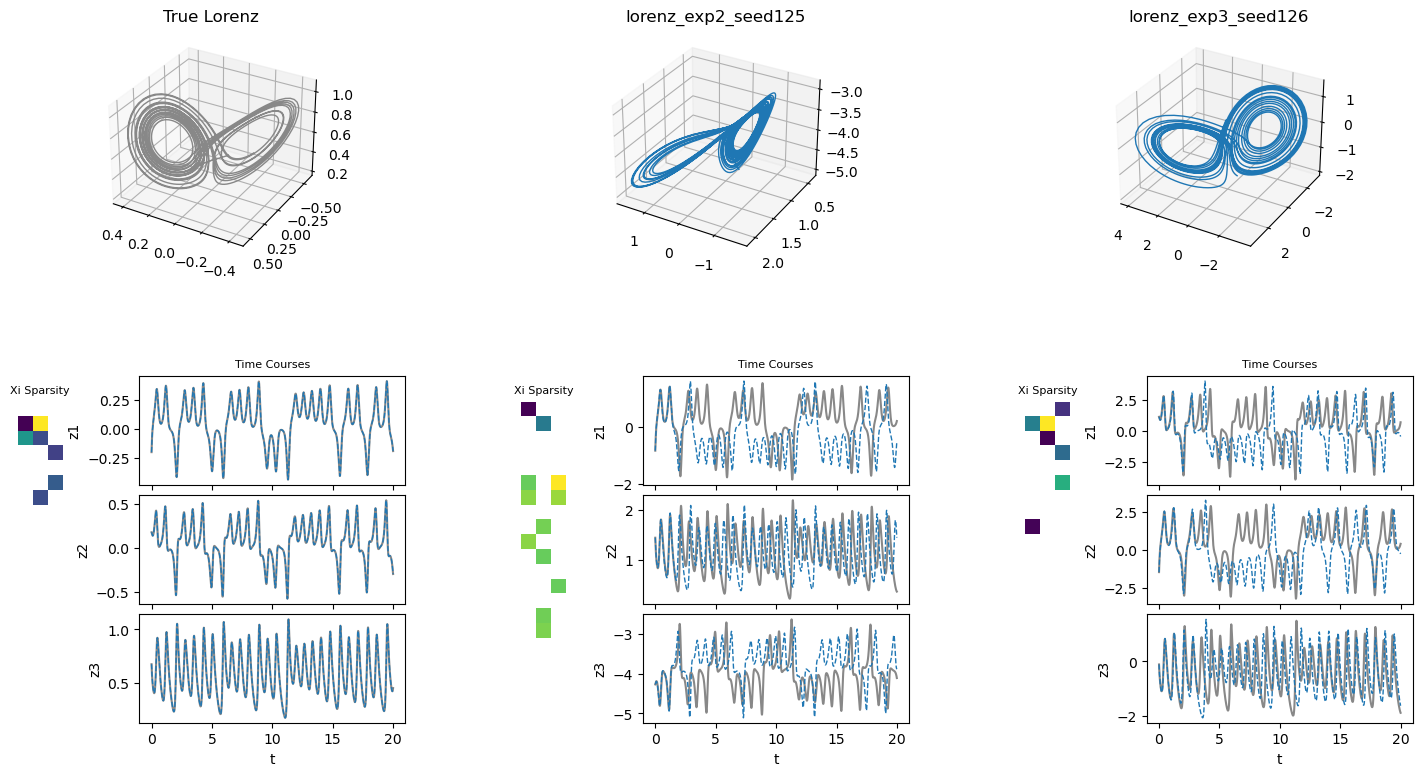

In [22]:
file_names = [
    'lorenz_exp0_seed123',
    'lorenz_exp1_seed124',
    'lorenz_exp2_seed125',
    'lorenz_exp3_seed126',
]

plot_lorenz_model_comparisons(
    exp_names=file_names,
    single_traj_results=single_traj_results,
    Xi_true=Xi_true_plot,
    get_Xi_plot_for_experiment=get_Xi_plot_for_experiment,
    t=t,
    save_prefix="lorenz_latsindy_compare",
)


In [23]:
print(len(t), t)

2000 [0.000e+00 1.000e-02 2.000e-02 ... 1.997e+01 1.998e+01 1.999e+01]
